# Partial Wasserstein and MMD

Notebook for the experiments in Thomas Viehmann: Partial Wasserstein and Maximum Mean Discrepancy distances for bridging the gap between outlier detection and drift detection.


In [1]:
# ! pip install pytorch-lightning --quiet
# ! pip install torchdrift
import ot

We import the world.

In [2]:
import torch
import torchvision
import os
import tqdm
import glob
import collections
import PIL
import numpy
import pytorch_lightning as pl
import torchdrift
from typing import Optional, Any
from matplotlib import pyplot

if True: # I sometimes have Jupyter incompatible with tqdm graphical output...
  torch.hub.tqdm = tqdm.tqdm
  torchvision.datasets.utils.tqdm = tqdm.tqdm
  pl.callbacks.progress.tqdm = tqdm.tqdm


## A model as feature extractor

We use the STL 10 dataset (as a balance simple / standard / not too small images) and a pretrained ResNet18 as the feature extractor with the twist that we have a 32 layer head part to get 32-dimensional features.


Next we wrap the dataset in a `LightningDataModule`.


In [3]:
# these are the standard transforms without the normalization (which we move into the model.step/predict before the forward)
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])

class OurDataModule(pl.LightningDataModule):
    def __init__(self, parent=None, additional_transform=None):
        super().__init__()
        if parent is None:
            self.train_dataset = torchvision.datasets.STL10('data', download=True, split='train',
                                                            transform=train_transform)
                     #FlowerDS(files, labels, numpy.concatenate([train_imgs, val_imgs]),
                     #                     transform=train_transform)
            self.val_dataset = None
            self.test_dataset = torchvision.datasets.STL10('data', split="test", transform=val_transform)
                    #FlowerDS(files, labels, test_imgs, transform=val_transform)
            self.train_batch_size = 16
            self.val_batch_size = 128
            self.additional_transform = None
        else:
            self.train_dataset = parent.train_dataset
            self.val_dataset = parent.val_dataset
            self.test_dataset = parent.test_dataset
            self.train_batch_size = parent.train_batch_size
            self.val_batch_size = parent.val_batch_size
            self.additional_transform = additional_transform
        if additional_transform is not None:
            self.additional_transform = additional_transform
        
        self.prepare_data()
        self.setup('fit')
        self.setup('test')

    def setup(self, stage):
        pass
    
    def collate_fn(self, batch):
        batch = torch.utils.data._utils.collate.default_collate(batch)
        if self.additional_transform:
            batch = (self.additional_transform(batch[0]), *batch[1:])
        return batch
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.train_batch_size, 
                                           num_workers=2, shuffle=True, collate_fn=self.collate_fn)
    def val_dataloader(self):
        return None

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.val_batch_size,
                                           num_workers=2, shuffle=False, collate_fn=self.collate_fn)

    def default_dataloader(self, batch_size=None, num_samples=None, shuffle=True):
        dataset = self.train_dataset
        if batch_size is None:
            batch_size = self.val_batch_size
        replacement = num_samples is not None
        if shuffle:
            sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=num_samples)
        else:
            sampler = None
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                                           collate_fn=self.collate_fn)


datamodule = OurDataModule()

Files already downloaded and verified


In [4]:
cat_names = datamodule.train_dataset.classes[:]

And build the LightningModule for training.

In [5]:
class Classifier(pl.LightningModule):
    def __init__(self, base_classifier):
        super().__init__()
        self.backbone = base_classifier
        self.backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad_(False)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, len(cat_names)))

    def normalize(self, x: torch.Tensor):
        # We pull the normalization, usually done in the dataset into the model forward
        x = torchvision.transforms.functional.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return x

    def forward(self, x: torch.Tensor):
        x = self.normalize(x)
        y = self.backbone(x)
        return self.classifier(y)

    def training_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    def test_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def predict(self, batch: Any, batch_idx: Optional[int]=None, dataloader_idx: Optional[int] = None):
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)



In [6]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()

model = Classifier(resnet)

trainer = pl.Trainer(max_epochs=20, gpus=1, checkpoint_callback=False, logger=False)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 136.42it/s, loss=0.478]


## Simulating drifted data

For experiments, we simulate out of distribution data by applying a gaussian blur. In reality you might have effects like the camera lense losing focus or dirt impeding the picture quality.

Note that we do not use the drifted data for "training" the drift detector, but just for evaluation!

On the technical side, we take our datamodule as the in-distribution datamodule as is and use a derived datamodule which applies the gaussian blur in addition to the usual transforms as the out of distribution datamodule.


In [7]:
def corruption_function(x: torch.Tensor):
    return torchdrift.data.functional.gaussian_blur(x, severity=5)

ind_datamodule = datamodule
ood_datamodule = OurDataModule(parent=datamodule, additional_transform=corruption_function)

Let us look at some pictures. (If you try this a few times, you will find that the vanilla model does reasonably well but the model performs considerably worse on the corrupted (blurred) images.

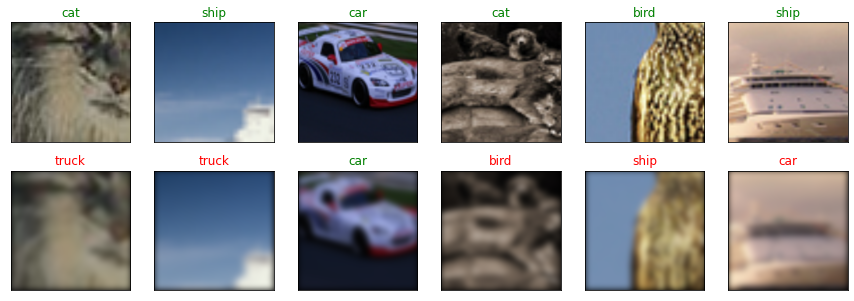

In [8]:
inputs, true_catids = next(iter(datamodule.default_dataloader(shuffle=True)))
inputs_ood = corruption_function(inputs)
N = 6
true_catids_2 = torch.cat([true_catids[:N], true_catids[:N]])
model.eval().cpu()
inps = torch.cat([inputs[:N], inputs_ood[:N]])
predictions = model.predict(inps).max(1).indices
true_labels = [cat_names[p] for p in true_catids_2]
predicted_labels = [cat_names[p] for p in predictions]

pyplot.figure(figsize=(15, 5))
for i in range(2 * N):
    pyplot.subplot(2, N, i + 1)
    title = pyplot.title(predicted_labels[i])
    pyplot.setp(title, color=('green' if true_labels[i] == predicted_labels[i] else 'red'))
    pyplot.imshow(inps[i].permute(1, 2, 0))
    pyplot.xticks([])
    pyplot.yticks([])

# Now we are ready for drift detection.

Let us recap the state here!

- We have a standard trained ResNet model (`model`).
- We have a dataset. The test set will simulate our production inputs
  with batches of 128.
- We have a corruption function. We apply this to a batch to similuate
  drift here. Note that we only use the corruption function *after* calibration.



# Drift detection


Center szenrario: 1000 reference and 50 test, fraction = 50/1000 = 5%, severity=3
Additional Scenario: fraction = 1, 100 or 1000 test (?) --> comparison to classical method
Random classes for biased test

Parameters to vary:

- Test size
- Fraction mismatch
- Corruption strength



In [9]:
# corruption_strength, test_size, fraction_to_match, wasserstein_p
experiments = [
    (3,  50, 0.05, 2.0),
    (2,  50, 0.05, 2.0),
    (4,  50, 0.05, 2.0),
    (3,  20, 0.02, 2.0),
    (3, 100, 0.10, 2.0),
    (3,  50, 0.02, 2.0),
    (3,  50, 0.10, 2.0),
    (3,  50, 0.05, 1.0),
    (3,  50, 0.05, 4.0),
]

In [10]:
def wasserstein(x, y, p=2.0, fraction_to_match=1.0, n_perm=1000, return_coupling=False):
    x = x.to(dtype=torch.float64)
    y = y.to(dtype=torch.float64)
    num_x, d = x.shape
    num_y, d2 = y.shape
    torchdrift.utils.check(
        d == d2, "Shape mismatch in feature dimension"
    )

    dists_p = torch.cdist(x, y, p=p) ** p
    if fraction_to_match < 1.0:
        max_dists_p = dists_p.max()
        dists_p = torch.cat([dists_p, (1.1 * max_dists_p).expand(num_x, 1)], dim=1)

    weights_x = torch.full_like(dists_p[:, 0], 1.0 / num_x)[None]
    weights_y = torch.full_like(dists_p[0, :], fraction_to_match / num_y)[None]
    if fraction_to_match < 1.0:
        weights_y[:, -1] = 1.0 - fraction_to_match

    coupling = torch.from_numpy(ot.emd(weights_x[0], weights_y[0], dists_p))

    if (coupling[:, :num_y].sum() / fraction_to_match - 1).abs().item() > 1e-5:
        raise RuntimeError("Numerical stability failed")
    wdist = ((coupling[:, :num_y] * dists_p[:, :num_y]).sum() / fraction_to_match)**(1 / p)

    if n_perm is None and return_coupling:
        return wdist, coupling
    elif n_perm is None:
        return wdist

    xy = torch.cat([x, y], dim=0)
    scores = []
    for i in range(n_perm):
        slicing = torch.randperm(num_x + num_y)
        dists_p_0 = torch.cdist(xy[slicing[:num_x]], xy[slicing[num_x:]], p=p) ** p
        if fraction_to_match < 1.0:
            max_dists_p_0 = dists_p_0.max()
            dists_p_0 = torch.cat([dists_p_0, (1.1 * max_dists_p_0).expand(num_x, 1)], dim=1)
        coupling_0 = torch.from_numpy(ot.emd(weights_x[0], weights_y[0], dists_p_0))

        if (coupling_0[:, :num_y].sum() / fraction_to_match - 1).abs().item() > 1e-5:
            raise RuntimeError("Numerical stability failed")
        scores.append(((coupling_0[:, :num_y] * dists_p_0[:, :num_y]).sum() / fraction_to_match)**(1 / p))        
    scores = torch.stack(scores)

    p_val = (wdist < scores).float().mean()
    if return_coupling:
        return wdist, p_val, coupling
    return wdist, p_val


class WassersteinDriftDetector(torchdrift.detectors.Detector):
    """Drift detector based on the Wasserstein distance.

    """

    def __init__(
        self, *, return_p_value=False, n_perm=1000, fraction_to_match=1.0, wasserstein_p = 2.0
    ):
        super().__init__(return_p_value=return_p_value)
        self.fraction_to_match = fraction_to_match
        self.wasserstein_p = wasserstein_p
        self.n_perm = n_perm
        self.n_test = None

    def fit(self, x: torch.Tensor, n_test=None, plot_title=None, plot_fn=None):
        """Record a sample as the reference distribution"""
        x = x.detach()
        if n_test is None:
            self.base_outputs = x
        else:
            torchdrift.utils.check(0 < n_test < x.size(0), "n_test must be strictly between 0 and the number of samples")
            self.n_test = n_test
            self.base_outputs = x[:-n_test]

            n_ref = x.size(0) - n_test
            with_distant_point = self.fraction_to_match < 1.0
            
            weights_x = torch.full((n_ref,), 1.0 / n_ref, device=x.device, dtype=torch.double)
            weights_y = torch.full((n_test + int(with_distant_point),), self.fraction_to_match / n_test, device=x.device, dtype=torch.double)
            if with_distant_point:
                weights_y[-1] = 1.0 - self.fraction_to_match
            p = self.wasserstein_p
            scores = []
            for i in range(self.n_perm):
                slicing = torch.randperm(x.size(0))
                dists_p_0 = torch.cdist(x[slicing[:-n_test]], x[slicing[-n_test:]], p=p) ** p
                if with_distant_point:
                    max_dists_p_0 = dists_p_0.max()
                    dists_p_0 = torch.cat([dists_p_0, (1.1 * max_dists_p_0).expand(n_ref, 1)], dim=1)
                coupling_0 = torch.from_numpy(ot.emd(weights_x, weights_y, dists_p_0))
                if (coupling_0[:, :n_test].sum() / self.fraction_to_match - 1).abs().item() > 1e-5:
                    raise RuntimeError("Numerical stability failed")
                scores.append(((coupling_0[:, :n_test] * dists_p_0[:, :n_test]).sum() / self.fraction_to_match)**(1 / p))
            scores = torch.stack(scores)

            #self.dist_mean = scores.mean()
            #self.dist_std = scores.std()
            self.scores = scores

            self.dist_min = scores.min().double()
            mean = scores.mean() - self.dist_min
            var = scores.var().double()
            self.dist_alpha = mean**2 / var
            self.dist_beta = mean / var

            if plot_title is not None:
                d = torch.distributions.Gamma(self.dist_alpha, self.dist_beta)
                xx = torch.linspace(0.00001, scores.max() - self.dist_min, 100)
                pyplot.figure()
                pyplot.title(plot_title)
                pyplot.plot(xx + self.dist_min, d.log_prob(xx).exp())
                pyplot.hist(scores.numpy(), bins=100, density=True)
                if plot_fn is not None:
                    pyplot.savefig(plot_fn, bbox_inches='tight')
                    pyplot.close()
                else:
                    pyplot.show()

        return x
    def predict_shift_from_features(
        self,
        base_outputs: torch.Tensor,
        outputs: torch.Tensor,
        compute_score: bool,
        compute_p_value: bool,
        individual_samples: bool = False,
    ):
        torchdrift.utils.check(
            not individual_samples, "Individual samples not supported by Wasserstein distance detector"
        )
        if not compute_p_value:
            ood_score = wasserstein(
                base_outputs, outputs, p=self.wasserstein_p, fraction_to_match=self.fraction_to_match,
                n_perm=None,
            )
            p_value = None
        elif self.n_test is None:
            ood_score, p_value = wasserstein(
                base_outputs, outputs, p=self.wasserstein_p, fraction_to_match=self.fraction_to_match,
                n_perm=self.n_perm)
        else:
            torchdrift.utils.check(self.n_test == outputs.size(0),
                                   "number of test samples does not match calibrated number")
            ood_score = wasserstein(
                base_outputs, outputs, p=self.wasserstein_p, fraction_to_match=self.fraction_to_match,
                n_perm=None)
            p_value = torch.igammac(self.dist_alpha, self.dist_beta * (ood_score - self.dist_min))  # needs PyTorch >=1.8
            # z = (ood_score - self.dist_mean) / self.dist_std
            # p_value = 0.5 * torch.erfc(z * (0.5**0.5))
            # p_value = (self.scores > ood_score).float().mean()
        return ood_score, p_value

class KernelMMDDriftDetector(torchdrift.detectors.Detector):
    """Drift detector based on the kernel Maximum Mean Discrepancy (MMD) test.

    This is modelled after the MMD drift detection in
    S. Rabanser et al: *Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift* (NeurIPS), 2019.

    Note that our heuristic choice of the kernel bandwith is more closely aligned with that of the original MMD paper and code than S. Rabanser's.

    The default kernel is the unnormalized Gaussian (or Squared Exponential) kernel.
    """

    def __init__(
        self, *, return_p_value=False, n_perm: int = 1000, kernel=torchdrift.detectors.mmd.GaussianKernel()
    ):
        super().__init__(return_p_value=return_p_value)
        self.n_perm = n_perm
        self.kernel = kernel
        self.n_test = None

    def fit(self, x: torch.Tensor, n_test=None, plot_title=None, plot_fn=None):
        """Record a sample as the reference distribution"""
        x = x.detach()
        if n_test is None:
            self.base_outputs = x
        else:
            torchdrift.utils.check(0 < n_test < x.size(0), "n_test must be strictly between 0 and the number of samples")
            self.n_test = n_test
            self.base_outputs = x[:-n_test]

            n_ref = x.size(0) - n_test

            scores = []
            for i in range(self.n_perm):
                slicing = torch.randperm(x.size(0))
                
                # note: kernel_mmd is symmetrix in x and y
                scores.append(torchdrift.detectors.kernel_mmd(
                    x[slicing[:-n_test]], x[slicing[-n_test:]], n_perm=None, kernel=self.kernel))

            scores = torch.stack(scores)

            # limited smallish sample sizes, the MMD appears to exhibit a nonzero offset
            # which vanishes in the limit we adapt. After correcting this, the gamma distribution
            # approximation suggested by Gretton et al seems very good.
            self.dist_min = scores.min().double()
            mean = scores.mean() - self.dist_min
            var = scores.var().double()
            self.dist_alpha = mean**2 / var
            self.dist_beta = mean / var

            if plot_title is not None:
                d = torch.distributions.Gamma(self.dist_alpha, self.dist_beta)
                xx = torch.linspace(0.00001, scores.max() - self.dist_min, 100)
                pyplot.figure()
                pyplot.title(plot_title)
                pyplot.plot(xx + self.dist_min, d.log_prob(xx).exp())
                pyplot.hist(scores.numpy(), bins=100, density=True)
                if plot_fn is not None:
                    pyplot.savefig(plot_fn, bbox_inches='tight')
                    pyplot.close()                    
                else:
                    pyplot.show()

    def predict_shift_from_features(
        self,
        base_outputs: torch.Tensor,
        outputs: torch.Tensor,
        compute_score: bool,
        compute_p_value: bool,
        individual_samples: bool = False,
    ):
        torchdrift.utils.check(
            not individual_samples, "Individual samples not supported by MMD detector"
        )
        if not compute_p_value:
            ood_score = torchdrift.detectors.kernel_mmd(
                outputs, base_outputs, n_perm=None, kernel=self.kernel
            )
            p_value = None
        elif self.n_test is None:
            ood_score, p_value = torchdrift.detectors.kernel_mmd(
                outputs, base_outputs, n_perm=self.n_perm, kernel=self.kernel
            )
        else:
            torchdrift.utils.check(self.n_test == outputs.size(0),
                                   "number of test samples does not match calibrated number")
            ood_score = torchdrift.detectors.kernel_mmd(
                outputs, base_outputs, n_perm=None, kernel=self.kernel
            )
            p_value = torch.igammac(self.dist_alpha, self.dist_beta * (ood_score - self.dist_min))  # needs PyTorch >=1.8
    
        return ood_score, p_value

In [11]:
def two_stage_partial_kernel_mmd(x, y, n_perm=None, kernel=torchdrift.detectors.mmd.GaussianKernel(),
                       fraction_to_match=1.0, wasserstein_p=2.0):

    n, d = x.shape
    m, d2 = y.shape
    if fraction_to_match < 1.0:
        _, coupling = wasserstein(x, y, fraction_to_match=fraction_to_match, return_coupling=True, n_perm=None,
                                  p=wasserstein_p)
        w = coupling[:, :-1].sum(1).to(device=x.device, dtype=x.dtype) / fraction_to_match
    else:
        w = torch.full((n,), 1.0 / n, device=x.device, dtype=x.dtype)
    torchdrift.utils.check(d == d2, "feature dimension mismatch")
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    k = kernel(dists) # here we neglect the weights for the partial match, unfortunately
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]
    # The diagonals are always 1 (up to numerical error, this is (3) in Gretton et al.)
    # note that their code uses the biased (and differently scaled mmd)
    mmd= (w @ k_x ) @ w + k_y.sum()/(m*m)  - 2 * (w @ k_xy).sum() / m
    #mmd = (
    #    k_x.sum() / (n * (n - 1)) + k_y.sum() / (m * (m - 1)) - 2 * k_xy.sum() / (n * m)
    #)
    if n_perm is None:
        return mmd
    raise NotImplementedError("Bootstraping within partial MMD is not implemented, use bootstrap during fit")

def partial_kernel_mmd(x, y, n_perm=None, kernel=torchdrift.detectors.mmd.GaussianKernel(),
                       fraction_to_match=1.0):
    n, d = x.shape
    m, d2 = y.shape
    torchdrift.utils.check(d == d2, "feature dimension mismatch")
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    k = kernel(dists.double())
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]

    v = torch.full((m,), 1/m, dtype=k_y.dtype, device=k_y.device)
    R = torch.cholesky(k_x, upper=True)
    d = torch.inverse(R.t()) @ (k_xy.sum(1) / m)
    LARGE = 1e7
    #A = torch.cat([R, torch.full((1, n,), LARGE, dtype=R.dtype, device=R.device)])
    #b = torch.cat([d, torch.full((1,), LARGE, dtype=R.dtype, device=R.device)])
    lb = torch.zeros((n,), dtype=k_x.dtype, device=k_x.device)
    ub = torch.full((n,), 1.0 / (n * fraction_to_match), dtype=k_x.dtype, device=k_x.device)
    w = torch.from_numpy(qpsolvers.solve_ls(R.numpy(), d.numpy(), lb=lb.numpy(), ub=ub.numpy(),
                                A=torch.ones((1, n,), dtype=R.dtype, device=R.device).numpy(),
                                b = torch.ones((1,), dtype=R.dtype, device=R.device).numpy()))
    # opt_res = scipy.optimize.lsq_linear(A, b, bounds=(lb, ub))
    # w = torch.from_numpy(opt_res.x)
    mmd= (w @ k_x ) @ w + k_y.sum()/(m*m)  - 2 * (w @ k_xy).sum() / m
    #mmd = (
    #    k_x.sum() / (n * n) + k_y.sum() / (m * m)
    #)
    return mmd

class TwoStageDriftDetector(torchdrift.detectors.Detector):

    def __init__(
        self, *, return_p_value=False, n_perm: int = 1000, kernel=torchdrift.detectors.mmd.GaussianKernel(),
        fraction_to_match=1.0, wasserstein_p=2.0
    ):
        super().__init__(return_p_value=return_p_value)
        self.n_perm = n_perm
        self.kernel = kernel
        self.fraction_to_match = fraction_to_match
        self.wasserstein_p = wasserstein_p
        self.n_test = None

    def fit(self, x: torch.Tensor, n_test=None, plot_title=None, plot_fn=None):
        """Record a sample as the reference distribution"""
        x = x.detach()
        if n_test is None:
            self.base_outputs = x
        else:
            torchdrift.utils.check(0 < n_test < x.size(0), "n_test must be strictly between 0 and the number of samples")
            self.n_test = n_test
            self.base_outputs = x[:-n_test]

            n_ref = x.size(0) - n_test

            scores = []
            for i in tqdm.tqdm(range(self.n_perm)):
                slicing = torch.randperm(x.size(0))
                
                # *partial* kernel mmd is not symmetric(!)
                scores.append(two_stage_partial_kernel_mmd(
                    x[slicing[:-n_test]], x[slicing[-n_test:]], n_perm=None, kernel=self.kernel,
                    fraction_to_match=self.fraction_to_match, wasserstein_p=self.wasserstein_p))

            scores = torch.stack(scores)

            # limited smallish sample sizes, the MMD appears to exhibit a nonzero offset
            # which vanishes in the limit we adapt. After correcting this, the gamma distribution
            # approximation suggested by Gretton et al seems very good.
            self.dist_min = scores.min().double()
            mean = scores.mean() - self.dist_min
            var = scores.var().double()
            self.dist_alpha = mean**2 / var
            self.dist_beta = mean / var

            if plot_title is not None:
                d = torch.distributions.Gamma(self.dist_alpha, self.dist_beta)
                xx = torch.linspace(0.00001, scores.max() - self.dist_min, 100)
                pyplot.figure()
                pyplot.title(plot_title)
                pyplot.plot(xx + self.dist_min, d.log_prob(xx).exp())
                pyplot.hist(scores.numpy(), bins=100, density=True)
                if plot_fn is not None:
                    pyplot.savefig(plot_fn, bbox_inches='tight')
                    pyplot.close()                    
                else:
                    pyplot.show()

    def predict_shift_from_features(
        self,
        base_outputs: torch.Tensor,
        outputs: torch.Tensor,
        compute_score: bool,
        compute_p_value: bool,
        individual_samples: bool = False,
    ):
        torchdrift.utils.check(
            not individual_samples, "Individual samples not supported by MMD detector"
        )
        if not compute_p_value:
            ood_score = two_stage_partial_kernel_mmd(
                base_outputs, outputs, n_perm=None, kernel=self.kernel,
                fraction_to_match=self.fraction_to_match, wasserstein_p=self.wasserstein_p
            )
            p_value = None
        elif self.n_test is None:
            torchdrift.utils.check(
                False, "Ad hoc boostrap not implemented"
            )
        else:
            torchdrift.utils.check(self.n_test == outputs.size(0),
                                   "number of test samples does not match calibrated number")
            ood_score = two_stage_partial_kernel_mmd(
                base_outputs, outputs, n_perm=None, kernel=self.kernel,
                fraction_to_match=self.fraction_to_match, wasserstein_p=self.wasserstein_p
            )
            p_value = torch.igammac(self.dist_alpha, self.dist_beta * (ood_score - self.dist_min))  # needs PyTorch >=1.8
            # overflow... map to 1.0
            p_value = torch.nan_to_num(p_value, nan=1.0)
    
        return ood_score, p_value

class PartialKernelMMDDriftDetector(torchdrift.detectors.Detector):

    def __init__(
        self, *, return_p_value=False, n_perm: int = 1000, kernel=torchdrift.detectors.mmd.GaussianKernel(),
        fraction_to_match=1.0
    ):
        super().__init__(return_p_value=return_p_value)
        self.n_perm = n_perm
        self.kernel = kernel
        self.fraction_to_match = fraction_to_match
        self.n_test = None

    def fit(self, x: torch.Tensor, n_test=None, plot_title=None, plot_fn=None):
        """Record a sample as the reference distribution"""
        x = x.detach()
        if n_test is None:
            self.base_outputs = x
        else:
            torchdrift.utils.check(0 < n_test < x.size(0), "n_test must be strictly between 0 and the number of samples")
            self.n_test = n_test
            self.base_outputs = x[:-n_test]

            n_ref = x.size(0) - n_test

            scores = []
            for i in tqdm.tqdm(range(self.n_perm)):
                slicing = torch.randperm(x.size(0))
                
                # *partial* kernel mmd is not symmetric(!)
                scores.append(partial_kernel_mmd(
                    x[slicing[:-n_test]], x[slicing[-n_test:]], n_perm=None, kernel=self.kernel,
                    fraction_to_match=self.fraction_to_match))

            scores = torch.stack(scores)

            # limited smallish sample sizes, the MMD appears to exhibit a nonzero offset
            # which vanishes in the limit we adapt. After correcting this, the gamma distribution
            # approximation suggested by Gretton et al seems very good.
            self.dist_min = scores.min().double()
            mean = scores.mean() - self.dist_min
            var = scores.var().double()
            self.dist_alpha = mean**2 / var
            self.dist_beta = mean / var

            if plot_title is not None:
                d = torch.distributions.Gamma(self.dist_alpha, self.dist_beta)
                xx = torch.linspace(0.00001, scores.max() - self.dist_min, 100)
                pyplot.figure()
                pyplot.title(plot_title)
                pyplot.plot(xx + self.dist_min, d.log_prob(xx).exp())
                pyplot.hist(scores.numpy(), bins=100, density=True)
                if plot_fn is not None:
                    pyplot.savefig(plot_fn, bbox_inches='tight')
                    pyplot.close()
                else:
                    pyplot.show()

    def predict_shift_from_features(
        self,
        base_outputs: torch.Tensor,
        outputs: torch.Tensor,
        compute_score: bool,
        compute_p_value: bool,
        individual_samples: bool = False,
    ):
        torchdrift.utils.check(
            not individual_samples, "Individual samples not supported by MMD detector"
        )
        if not compute_p_value:
            ood_score = partial_kernel_mmd(
                base_outputs, outputs, n_perm=None, kernel=self.kernel,
                fraction_to_match=self.fraction_to_match
            )
            p_value = None
        elif self.n_test is None:
            torchdrift.utils.check(
                False, "Ad hoc boostrap not implemented"
            )
        else:
            torchdrift.utils.check(self.n_test == outputs.size(0),
                                   "number of test samples does not match calibrated number")
            ood_score = partial_kernel_mmd(
                base_outputs, outputs, n_perm=None, kernel=self.kernel,
                fraction_to_match=self.fraction_to_match
            )
            p_value = torch.igammac(self.dist_alpha, self.dist_beta * (ood_score - self.dist_min))  # needs PyTorch >=1.8
            # overflow... map to 1.0
            p_value = torch.nan_to_num(p_value, nan=1.0)
    
        return ood_score, p_value

In [12]:
model_accs = []
all_results = {}
for run_nr in range(10):
    resnet = torchvision.models.resnet18(pretrained=True)
    resnet.fc = torch.nn.Identity()

    model = Classifier(resnet)

    trainer = pl.Trainer(max_epochs=20, gpus=1, checkpoint_callback=False, logger=False)
    trainer.fit(model, datamodule)

    accs = [(0, trainer.test(model=model, datamodule=datamodule)[0]['test_acc'])]
    for corruption_strength in [2, 3, 4]:
        def corruption_function(x: torch.Tensor):
            return torchdrift.data.functional.gaussian_blur(x, severity=corruption_strength)
        corr_dm = OurDataModule(parent=datamodule, additional_transform=corruption_function)
        accs.append((corruption_strength, trainer.test(model=model, datamodule=corr_dm)[0]['test_acc']))
    model_accs.append(accs)
    print('accs', accs)

    ref_dataset = torchvision.datasets.STL10("data", split="train", transform=val_transform)
    val_dataset = torchvision.datasets.STL10("data", split="test", transform=val_transform)
    biased_subsets = [torch.utils.data.Subset(val_dataset, (val_dataset.labels == i).nonzero()[0]) for i in range(10)]


    # careful: sharing modules and parameters!
    feature_extractor = torch.nn.Sequential(model.backbone, model.classifier[0])
    feature_extractor.eval().cuda()
    model.eval().cuda()


    for corruption_strength, N_test, fraction_to_match, wasserstein_p in experiments:
        base_fn = f'experiment.stl10rn18.run_{run_nr}.{corruption_strength=}-{N_test=}-{fraction_to_match=}-{wasserstein_p=}'.replace('=', '_')
        print(base_fn)
        idx = torch.randperm(len(ref_dataset))
        ref_images = torch.stack([ref_dataset[idx[i]][0] for i in range(min(len(ref_dataset), 1000 + N_test))], dim=0)

        with torch.no_grad():
            ref_features = feature_extractor(ref_images.cuda()).cpu()

        dd_mmd = KernelMMDDriftDetector()
        dd_mmd.fit(ref_features, n_test=N_test, plot_title=f'mmd N_test={N_test}', plot_fn=base_fn + '.mmd_fit.pdf');

        dd_wfull = WassersteinDriftDetector()
        dd_wfull.fit(ref_features, n_test=N_test, plot_title=f'w full p={wasserstein_p} N_test={N_test}', plot_fn=base_fn + '.wfull_fit.pdf');

        dd_partial = WassersteinDriftDetector(fraction_to_match=fraction_to_match)
        dd_partial.fit(ref_features, n_test=N_test, plot_title=f'w partial({fraction_to_match}) p={wasserstein_p} N_test={N_test}', plot_fn=base_fn + '.wpart_fit.pdf');

        dd_twostage = TwoStageDriftDetector(fraction_to_match=fraction_to_match)
        dd_twostage.fit(ref_features, n_test=N_test, plot_title=f'twostage({fraction_to_match}) p={wasserstein_p} N_test={N_test}', plot_fn=base_fn + '.twostage_fit.pdf')

        p_values = collections.defaultdict(list)

        def corruption_function(x: torch.Tensor):
            return torchdrift.data.functional.gaussian_blur(x, severity=corruption_strength)

        dl_random = torch.utils.data.DataLoader(
                    val_dataset, batch_size=N_test,
                    sampler=torch.utils.data.RandomSampler(val_dataset, replacement=True, num_samples=N_test * 1000),
                    num_workers=4)
        it_random = iter(dl_random)
        for i in tqdm.tqdm(range(1000)):
            if i % 100 == 0:
                cur_ds_biased = biased_subsets[i // 100]
                dl_biased = torch.utils.data.DataLoader(
                    cur_ds_biased, batch_size=N_test,
                    sampler=torch.utils.data.RandomSampler(cur_ds_biased, replacement=True, num_samples=N_test * 100),
                                                          num_workers=4)
                it_biased = iter(dl_biased)
            # random class
            #cl = torch.randint(len(cat_names), ()).item()
            #one_class = torch.nonzero(torch.from_numpy(val_dataset.labels)==cl)
            #one_class = one_class[torch.randperm(one_class.size(0))]
            #test_idx_imbal = one_class[:N_test]
            #test_points_imbal = [val_dataset[i] for i in test_idx_imbal]
            #test_labels_imbal = torch.tensor([l for i, l in test_points_imbal])
            #test_images_imbal = torch.stack([i for i, l in test_points_imbal], dim=0).cuda()
            # this is randomly drawn
            # test_points_rand = [val_dataset[i] for i in torch.randperm(len(val_dataset))[:N_test]]
            # test_labels_rand = torch.tensor([l for i, l in test_points_rand])
            # test_images_rand = torch.stack([i for i, l in test_points_rand], dim=0).cuda()
            test_images_imbal, test_labels_imbal = next(it_biased)
            test_images_rand, test_labels_rand = next(it_random)
            test_images_imbal = test_images_imbal.cuda()
            test_images_rand = test_images_rand.cuda()

            test_images_imbal_corr = corruption_function(test_images_imbal)
            test_images_rand_corr = corruption_function(test_images_rand)

            with torch.no_grad():
                test_features_imbal = feature_extractor(test_images_imbal)
                test_features_rand = feature_extractor(test_images_rand)
                test_features_imbal_corr = feature_extractor(test_images_imbal_corr)
                test_features_rand_corr = feature_extractor(test_images_rand_corr)

            test_features_imbal = test_features_imbal.cpu()
            test_features_rand = test_features_rand.cpu()
            test_features_imbal_corr = test_features_imbal_corr.cpu()
            test_features_rand_corr = test_features_rand_corr.cpu()

            p_values['mmd-imbal'].append(dd_mmd.compute_p_value(test_features_imbal))
            p_values['mmd-bal'].append(dd_mmd.compute_p_value(test_features_rand))
            p_values['wfull-imbal'].append(dd_wfull.compute_p_value(test_features_imbal))
            p_values['wfull-bal'].append(dd_wfull.compute_p_value(test_features_rand))
            p_values['wpartial-imbal'].append(dd_partial.compute_p_value(test_features_imbal))
            p_values['wpartial-bal'].append(dd_partial.compute_p_value(test_features_rand))
            p_values['wpartial-imbal-vals'].append(dd_partial(test_features_imbal))
            p_values['wpartial-bal-vals'].append(dd_partial(test_features_rand))
            p_values['twostage-imbal'].append(dd_twostage.compute_p_value(test_features_imbal))
            p_values['twostage-bal'].append(dd_twostage.compute_p_value(test_features_rand))
            p_values['mmd-imbal-corr'].append(dd_mmd.compute_p_value(test_features_imbal_corr))
            p_values['mmd-bal-corr'].append(dd_mmd.compute_p_value(test_features_rand_corr))
            p_values['wfull-imbal-corr'].append(dd_wfull.compute_p_value(test_features_imbal_corr))
            p_values['wfull-bal-corr'].append(dd_wfull.compute_p_value(test_features_rand_corr))
            p_values['wpartial-imbal-corr'].append(dd_partial.compute_p_value(test_features_imbal_corr))
            p_values['wpartial-bal-corr'].append(dd_partial.compute_p_value(test_features_rand_corr))
            p_values['twostage-imbal-corr'].append(dd_twostage.compute_p_value(test_features_imbal_corr))
            p_values['twostage-bal-corr'].append(dd_twostage.compute_p_value(test_features_rand_corr))

        p_values = {k: torch.stack(v) for k, v in p_values.items()}
        all_results[base_fn] = p_values

        del it_biased
        del it_random
        
        
        pyplot.figure(figsize=(15, 10))
        pyplot.suptitle(f'p-values computed by drift detection ({corruption_strength=}, {N_test=}, {fraction_to_match=}, {wasserstein_p=})')
        pyplot.subplots_adjust(hspace=0.4)
        for i, ddname in enumerate(['mmd', 'wfull', 'wpartial', 'twostage']):
            for j, inputname in enumerate(['bal', 'imbal', 'bal-corr', 'imbal-corr']):
                k = f'{ddname}-{inputname}'
                v = p_values[k]
                pyplot.subplot(4, 4, 4 * i + j + 1)
                pyplot.title(k)
                pyplot.hist(v.numpy(), density=True)
        pyplot.savefig(base_fn + '.histograms_of_p.pdf')
        pyplot.close()
        # pyplot.show()

        pyplot.figure()
        for ddname in ['mmd', 'wfull', 'wpartial', 'twostage']:
            pyplot.title(f'ROC with 50% imbal  ({corruption_strength=}, {N_test=}, {fraction_to_match=}, {wasserstein_p=})')

            allpreds = torch.cat([p_values[f'{ddname}-imbal-corr'], p_values[f'{ddname}-bal-corr'], p_values[f'{ddname}-imbal'], p_values[f'{ddname}-bal']])

            pos_neg = ((allpreds.argsort() < len(p_values[f'{ddname}-imbal-corr']) + len(p_values[f'{ddname}-bal-corr'])).float())

            tp = torch.cumsum(pos_neg, 0) / pos_neg.sum()
            fp = torch.cumsum(1 - pos_neg, 0) / (1 - pos_neg).sum()


            fp_diff = fp[1:] - fp[:-1]
            tp_avg = (tp[1:] + tp[:-1]) / 2
            auc = (fp_diff * tp_avg).sum()

            pyplot.plot(fp, tp, label=f'{ddname} AUC: {auc:.2f}')
            pyplot.legend()
        pyplot.savefig(base_fn + '.roc.pdf')
        pyplot.close()
        # pyplot.show()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 138.36it/s, loss=0.553]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 63/63 [00:03<00:00, 21.12it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9316250085830688, 'test_loss': 0.2041691541671753}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 19.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 63/63 [00:28<00:00,  2.73it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8661249876022339, 'test_loss': 0.3938400447368622}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:49<00:00,  1.49it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.762499988079071, 'test_loss': 0.6914559602737427}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:36<00:00,  1.22s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6000000238418579, 'test_loss': 1.1294397115707397}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]
accs [(0, 0.9316250085830688), (2, 0.8661249876022339), (3, 0.762499988079071), (4, 0.6000000238418579)]
experiment.stl10rn18.run_0.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


experiment.stl10rn18.run_0.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


experiment.stl10rn18.run_0.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


experiment.stl10rn18.run_0.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:02<00:00,  8.18it/s]


experiment.stl10rn18.run_0.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]


experiment.stl10rn18.run_0.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


experiment.stl10rn18.run_0.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


experiment.stl10rn18.run_0.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


experiment.stl10rn18.run_0.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 139.22it/s, loss=0.482]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.33it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.940625011920929, 'test_loss': 0.1842556595802307}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 18.42it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:28<00:00,  2.60it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.84375, 'test_loss': 0.4491051137447357}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:28<00:00,  2.19it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.47it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7182499766349792, 'test_loss': 0.7814860343933105}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:36<00:00,  1.26s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5417500138282776, 'test_loss': 1.2577232122421265}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]
accs [(0, 0.940625011920929), (2, 0.84375), (3, 0.7182499766349792), (4, 0.5417500138282776)]
experiment.stl10rn18.run_1.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


experiment.stl10rn18.run_1.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:50<00:00,  5.88it/s]


experiment.stl10rn18.run_1.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]


experiment.stl10rn18.run_1.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]


experiment.stl10rn18.run_1.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


experiment.stl10rn18.run_1.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s]


experiment.stl10rn18.run_1.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


experiment.stl10rn18.run_1.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


experiment.stl10rn18.run_1.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 131.91it/s, loss=0.556]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.54it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.937375009059906, 'test_loss': 0.1875825971364975}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 18.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:28<00:00,  2.56it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8617500066757202, 'test_loss': 0.4035875201225281}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.49it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7662500143051147, 'test_loss': 0.6924465298652649}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:38<00:00,  1.33s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6004999876022339, 'test_loss': 1.1103354692459106}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]
accs [(0, 0.937375009059906), (2, 0.8617500066757202), (3, 0.7662500143051147), (4, 0.6004999876022339)]
experiment.stl10rn18.run_2.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:55<00:00,  5.71it/s]


experiment.stl10rn18.run_2.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


experiment.stl10rn18.run_2.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s]


experiment.stl10rn18.run_2.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [01:55<00:00,  8.65it/s]


experiment.stl10rn18.run_2.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


experiment.stl10rn18.run_2.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


experiment.stl10rn18.run_2.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


experiment.stl10rn18.run_2.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


experiment.stl10rn18.run_2.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 134.70it/s, loss=0.502]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.33it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.937749981880188, 'test_loss': 0.18760964274406433}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 18.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:28<00:00,  2.57it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8633750081062317, 'test_loss': 0.39969679713249207}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.48it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7453749775886536, 'test_loss': 0.7173734903335571}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:36<00:00,  1.28s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5577499866485596, 'test_loss': 1.2015169858932495}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]
accs [(0, 0.937749981880188), (2, 0.8633750081062317), (3, 0.7453749775886536), (4, 0.5577499866485596)]
experiment.stl10rn18.run_3.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


experiment.stl10rn18.run_3.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


experiment.stl10rn18.run_3.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:02<00:00,  5.49it/s]


experiment.stl10rn18.run_3.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:01<00:00,  8.20it/s]


experiment.stl10rn18.run_3.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


experiment.stl10rn18.run_3.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


experiment.stl10rn18.run_3.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s]


experiment.stl10rn18.run_3.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s]


experiment.stl10rn18.run_3.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 134.47it/s, loss=0.414]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.49it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9330000281333923, 'test_loss': 0.19882407784461975}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 18.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:29<00:00,  2.56it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8604999780654907, 'test_loss': 0.4063473045825958}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.47it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7540000081062317, 'test_loss': 0.7058014869689941}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:37<00:00,  1.18s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5893750190734863, 'test_loss': 1.1371574401855469}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:37<00:00,  1.55s/it]
accs [(0, 0.9330000281333923), (2, 0.8604999780654907), (3, 0.7540000081062317), (4, 0.5893750190734863)]
experiment.stl10rn18.run_4.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


experiment.stl10rn18.run_4.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]


experiment.stl10rn18.run_4.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


experiment.stl10rn18.run_4.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]


experiment.stl10rn18.run_4.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


experiment.stl10rn18.run_4.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:58<00:00,  5.62it/s]


experiment.stl10rn18.run_4.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:59<00:00,  5.56it/s]


experiment.stl10rn18.run_4.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


experiment.stl10rn18.run_4.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:55<00:00,  5.71it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 133.25it/s, loss=0.389]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.36it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9311249852180481, 'test_loss': 0.2106703370809555}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 18.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:28<00:00,  2.58it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8569999933242798, 'test_loss': 0.4176304340362549}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing:  98%|█████████▊| 62/63 [00:51<00:00,  1.19it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7473750114440918, 'test_loss': 0.7332946062088013}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:36<00:00,  1.27s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5707499980926514, 'test_loss': 1.1765602827072144}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]
accs [(0, 0.9311249852180481), (2, 0.8569999933242798), (3, 0.7473750114440918), (4, 0.5707499980926514)]
experiment.stl10rn18.run_5.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s]


experiment.stl10rn18.run_5.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]


experiment.stl10rn18.run_5.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]


experiment.stl10rn18.run_5.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]


experiment.stl10rn18.run_5.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]


experiment.stl10rn18.run_5.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


experiment.stl10rn18.run_5.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


experiment.stl10rn18.run_5.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


experiment.stl10rn18.run_5.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 132.85it/s, loss=0.496]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 17.51it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9346250295639038, 'test_loss': 0.19649094343185425}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 16.52it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:29<00:00,  2.86it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.859375, 'test_loss': 0.42343541979789734}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.49it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7494999766349792, 'test_loss': 0.7298446297645569}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:38<00:00,  1.29s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5958750247955322, 'test_loss': 1.1331992149353027}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]
accs [(0, 0.9346250295639038), (2, 0.859375), (3, 0.7494999766349792), (4, 0.5958750247955322)]
experiment.stl10rn18.run_6.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


experiment.stl10rn18.run_6.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


experiment.stl10rn18.run_6.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:05<00:00,  5.40it/s]


experiment.stl10rn18.run_6.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


experiment.stl10rn18.run_6.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


experiment.stl10rn18.run_6.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


experiment.stl10rn18.run_6.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s]


experiment.stl10rn18.run_6.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


experiment.stl10rn18.run_6.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 134.78it/s, loss=0.567]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.62it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9403749704360962, 'test_loss': 0.18026092648506165}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 17.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 63/63 [00:29<00:00,  2.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8544999957084656, 'test_loss': 0.42424947023391724}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.47it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7336249947547913, 'test_loss': 0.7436879873275757}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:37<00:00,  1.26s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5699999928474426, 'test_loss': 1.1676985025405884}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:38<00:00,  1.56s/it]
accs [(0, 0.9403749704360962), (2, 0.8544999957084656), (3, 0.7336249947547913), (4, 0.5699999928474426)]
experiment.stl10rn18.run_7.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


experiment.stl10rn18.run_7.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


experiment.stl10rn18.run_7.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


experiment.stl10rn18.run_7.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


experiment.stl10rn18.run_7.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


experiment.stl10rn18.run_7.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s]


experiment.stl10rn18.run_7.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


experiment.stl10rn18.run_7.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


experiment.stl10rn18.run_7.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 128.77it/s, loss=0.521]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.02it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9375, 'test_loss': 0.19266216456890106}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 17.57it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:28<00:00,  2.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8661249876022339, 'test_loss': 0.3918364644050598}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:51<00:00,  1.45it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7637500166893005, 'test_loss': 0.6847904324531555}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing:  98%|█████████▊| 62/63 [01:36<00:01,  1.52s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6035000085830688, 'test_loss': 1.104831576347351}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]
accs [(0, 0.9375), (2, 0.8661249876022339), (3, 0.7637500166893005), (4, 0.6035000085830688)]
experiment.stl10rn18.run_8.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s]


experiment.stl10rn18.run_8.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


experiment.stl10rn18.run_8.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


experiment.stl10rn18.run_8.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:02<00:00,  8.13it/s]


experiment.stl10rn18.run_8.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


experiment.stl10rn18.run_8.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]


experiment.stl10rn18.run_8.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:59<00:00,  5.56it/s]


experiment.stl10rn18.run_8.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


experiment.stl10rn18.run_8.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Sequential | 16.7 K
------------------------------------------
16.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.773    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 313/313 [00:02<00:00, 130.94it/s, loss=0.423]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  97%|█████████▋| 61/63 [00:03<00:00, 19.50it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9348750114440918, 'test_loss': 0.1920311599969864}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:03<00:00, 17.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 63/63 [00:29<00:00,  2.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8651250004768372, 'test_loss': 0.39868324995040894}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [00:50<00:00,  1.48it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7637500166893005, 'test_loss': 0.6838305592536926}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 63/63 [01:37<00:00,  1.20s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6200000047683716, 'test_loss': 1.08381187915802}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 63/63 [01:37<00:00,  1.54s/it]
accs [(0, 0.9348750114440918), (2, 0.8651250004768372), (3, 0.7637500166893005), (4, 0.6200000047683716)]
experiment.stl10rn18.run_9.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


experiment.stl10rn18.run_9.corruption_strength_2-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


experiment.stl10rn18.run_9.corruption_strength_4-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


experiment.stl10rn18.run_9.corruption_strength_3-N_test_20-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:04<00:00,  8.03it/s]


experiment.stl10rn18.run_9.corruption_strength_3-N_test_100-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]


experiment.stl10rn18.run_9.corruption_strength_3-N_test_50-fraction_to_match_0.02-wasserstein_p_2.0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


experiment.stl10rn18.run_9.corruption_strength_3-N_test_50-fraction_to_match_0.1-wasserstein_p_2.0


100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s]


experiment.stl10rn18.run_9.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_1.0


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


experiment.stl10rn18.run_9.corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_4.0


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


In [ ]:
import datetime
import torch
datetime = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
torch.save([all_results, model_accs], f'all_results.{datetime}.pt')

# Aggregate statistics evaluation

In [14]:
all_results, model_accs = torch.load('all_results.2021-06-09-14-56.pt')

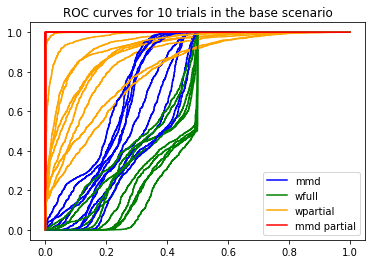

In [22]:
ccodes = {'mmd': 'blue', 'wfull': 'green', 'wpartial': 'orange', 'twostage': 'red'}
aucs = collections.defaultdict(lambda: collections.defaultdict(list))
base_name = 'corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0'

decile_counts = collections.defaultdict(lambda: collections.defaultdict(list))
for k, p_values in all_results.items():
    for ddname in ['mmd', 'wfull', 'wpartial', 'twostage']:

        allpreds = torch.cat([p_values[f'{ddname}-imbal-corr'], p_values[f'{ddname}-bal-corr'], p_values[f'{ddname}-imbal'], p_values[f'{ddname}-bal']])

        pos_neg = ((allpreds.argsort() < len(p_values[f'{ddname}-imbal-corr']) + len(p_values[f'{ddname}-bal-corr'])).float())

        tp = torch.cumsum(pos_neg, 0) / pos_neg.sum()
        fp = torch.cumsum(1 - pos_neg, 0) / (1 - pos_neg).sum()


        fp_diff = fp[1:] - fp[:-1]
        tp_avg = (tp[1:] + tp[:-1]) / 2
        auc = (fp_diff * tp_avg).sum()
        ksuf = 'corruption' + k.split('.corruption')[1]
        aucs[ksuf][ddname].append(auc.item())
        
        ddname_print = ddname if ddname != 'twostage' else 'mmd partial'
        if ksuf == base_name:
            pyplot.plot(fp, tp, label=(f'{ddname_print}' if 'run_0' in k else None), color=ccodes[ddname])

        for kk in [f'{ddname}-imbal-corr', f'{ddname}-bal-corr', f'{ddname}-imbal', f'{ddname}-bal']:
            decile_counts[ksuf][kk].append(torch.histc(p_values[kk], bins=10, min=0, max=1))

pyplot.legend()
pyplot.title('ROC curves for 10 trials in the base scenario')
pyplot.savefig('roc-curves-10-trials-base.pdf')

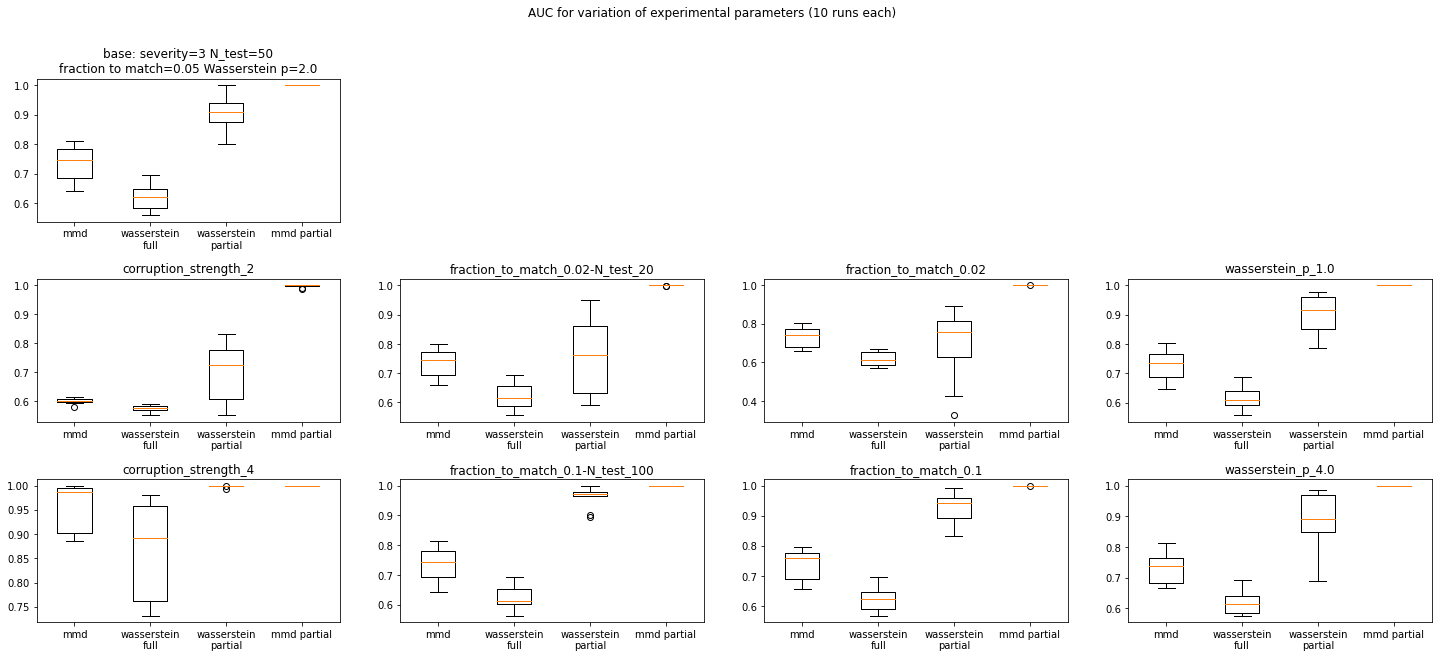

In [21]:
pyplot.figure(figsize=(25, 10))
pyplot.suptitle('AUC for variation of experimental parameters (10 runs each)')#, y=0.91)
pyplot.subplots_adjust(hspace=0.4)
base_name = 'corruption_strength_3-N_test_50-fraction_to_match_0.05-wasserstein_p_2.0'
setbase = set(base_name.split('-'))
for i, (k, d) in enumerate(aucs.items()):
    if i == 0:
        pos = 1
    else:
        pos = 5 + (i-1) // 2 + 4 * ((i-1) % 2)
    pyplot.subplot(3, 4, pos)
    if k != base_name:
        pyplot.title('-'.join(set(k.split('-')) - setbase))
    else:
        pyplot.title('base: severity=3 N_test=50\nfraction to match=0.05 Wasserstein p=2.0')
    t = torch.stack([torch.tensor(d[k]) for k in ['mmd', 'wfull', 'wpartial', 'twostage']], 1)
    pyplot.boxplot(t.numpy())
    pyplot.xticks(ticks=[1, 2, 3, 4], labels=['mmd', 'wasserstein\nfull', 'wasserstein\npartial', 'mmd partial'])
pyplot.savefig('auc_for_sensitivities.pdf', bbox_inches='tight')

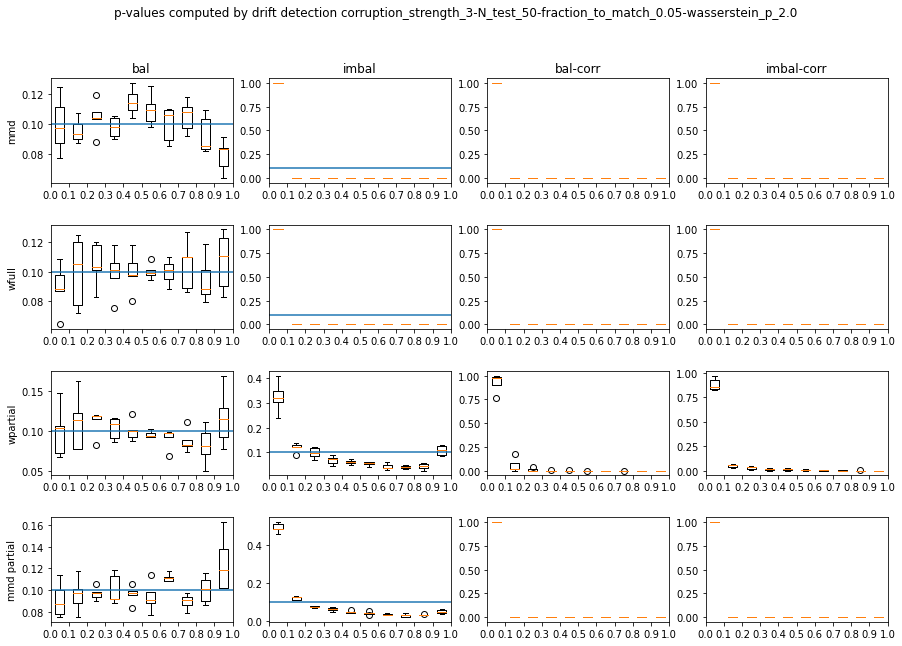

In [26]:
for i, (k, d) in enumerate(decile_counts.items()):
    if k == base_name:
        pyplot.figure(figsize=(15, 10))
        pyplot.suptitle(f'p-values computed by drift detection {k}')
        pyplot.subplots_adjust(hspace=0.4)
        for i, ddname in enumerate(['mmd', 'wfull', 'wpartial', 'twostage']):
            for j, inputname in enumerate(['bal', 'imbal', 'bal-corr', 'imbal-corr']):
                
                kk = f'{ddname}-{inputname}'
                v = torch.stack(d[kk])[:5]/ 1000.
                pyplot.subplot(4, 4, 4 * i + j + 1)
                ddname_print = ddname if ddname != 'twostage' else 'mmd partial'
                if i == 0:
                    pyplot.title(inputname)
                if j == 0:
                    pyplot.ylabel(ddname_print)
                pyplot.boxplot(v.numpy())
                if j < 2:
                    pyplot.plot([0.5, 10.5], [0.1, 0.1])
                pyplot.xticks(ticks=[x+0.5 for x in range(11)],
                              labels=[x / 10 for x in range(11)])
pyplot.savefig('deciles_with_error_bars_base.pdf')

## END OF STATISTICS EVAL

## QP-based  partial MMD (too slow)


In [ ]:
# This is too slow...
def partial_kernel_mmd(x, y, n_perm=None, kernel=torchdrift.detectors.mmd.GaussianKernel(),
                       fraction_to_match=1.0):
    n, d = x.shape
    m, d2 = y.shape
    torchdrift.utils.check(d == d2, "feature dimension mismatch")
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    k = kernel(dists.double())
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]

    v = torch.full((m,), 1/m, dtype=k_y.dtype, device=k_y.device)
    R = torch.cholesky(k_x, upper=True)
    d = torch.inverse(R.t()) @ (k_xy.sum(1) / m)
    LARGE = 1e7
    #A = torch.cat([R, torch.full((1, n,), LARGE, dtype=R.dtype, device=R.device)])
    #b = torch.cat([d, torch.full((1,), LARGE, dtype=R.dtype, device=R.device)])
    lb = torch.zeros((n,), dtype=k_x.dtype, device=k_x.device)
    ub = torch.full((n,), 1.0 / (n * fraction_to_match), dtype=k_x.dtype, device=k_x.device)
    w = torch.from_numpy(qpsolvers.solve_ls(R.numpy(), d.numpy(), lb=lb.numpy(), ub=ub.numpy(),
                                A=torch.ones((1, n,), dtype=R.dtype, device=R.device).numpy(),
                                b = torch.ones((1,), dtype=R.dtype, device=R.device).numpy()))
    # opt_res = scipy.optimize.lsq_linear(A, b, bounds=(lb, ub))
    # w = torch.from_numpy(opt_res.x)
    mmd= (w @ k_x ) @ w + k_y.sum()/(m*m)  - 2 * (w @ k_xy).sum() / m
    #mmd = (
    #    k_x.sum() / (n * n) + k_y.sum() / (m * m)
    #)
    return mmd

class PartialKernelMMDDriftDetector(torchdrift.detectors.Detector):

    def __init__(
        self, *, return_p_value=False, n_perm: int = 1000, kernel=torchdrift.detectors.mmd.GaussianKernel(),
        fraction_to_match=1.0
    ):
        super().__init__(return_p_value=return_p_value)
        self.n_perm = n_perm
        self.kernel = kernel
        self.fraction_to_match = fraction_to_match
        self.n_test = None

    def fit(self, x: torch.Tensor, n_test=None, plot_title=None, plot_fn=None):
        """Record a sample as the reference distribution"""
        x = x.detach()
        if n_test is None:
            self.base_outputs = x
        else:
            torchdrift.utils.check(0 < n_test < x.size(0), "n_test must be strictly between 0 and the number of samples")
            self.n_test = n_test
            self.base_outputs = x[:-n_test]

            n_ref = x.size(0) - n_test

            scores = []
            for i in tqdm.tqdm(range(self.n_perm)):
                slicing = torch.randperm(x.size(0))
                
                # *partial* kernel mmd is not symmetric(!)
                scores.append(partial_kernel_mmd(
                    x[slicing[:-n_test]], x[slicing[-n_test:]], n_perm=None, kernel=self.kernel,
                    fraction_to_match=self.fraction_to_match))

            scores = torch.stack(scores)

            # limited smallish sample sizes, the MMD appears to exhibit a nonzero offset
            # which vanishes in the limit we adapt. After correcting this, the gamma distribution
            # approximation suggested by Gretton et al seems very good.
            self.dist_min = scores.min().double()
            mean = scores.mean() - self.dist_min
            var = scores.var().double()
            self.dist_alpha = mean**2 / var
            self.dist_beta = mean / var

            if plot_title is not None:
                d = torch.distributions.Gamma(self.dist_alpha, self.dist_beta)
                xx = torch.linspace(0.00001, scores.max() - self.dist_min, 100)
                pyplot.figure()
                pyplot.title(plot_title)
                pyplot.plot(xx + self.dist_min, d.log_prob(xx).exp())
                pyplot.hist(scores.numpy(), bins=100, density=True)
                if plot_fn is not None:
                    pyplot.savefig(plot_fn, bbox_inches='tight')
                    pyplot.close()
                else:
                    pyplot.show()

    def predict_shift_from_features(
        self,
        base_outputs: torch.Tensor,
        outputs: torch.Tensor,
        compute_score: bool,
        compute_p_value: bool,
        individual_samples: bool = False,
    ):
        torchdrift.utils.check(
            not individual_samples, "Individual samples not supported by MMD detector"
        )
        if not compute_p_value:
            ood_score = partial_kernel_mmd(
                base_outputs, outputs, n_perm=None, kernel=self.kernel,
                fraction_to_match=self.fraction_to_match
            )
            p_value = None
        elif self.n_test is None:
            torchdrift.utils.check(
                False, "Ad hoc boostrap not implemented"
            )
        else:
            torchdrift.utils.check(self.n_test == outputs.size(0),
                                   "number of test samples does not match calibrated number")
            ood_score = partial_kernel_mmd(
                base_outputs, outputs, n_perm=None, kernel=self.kernel,
                fraction_to_match=self.fraction_to_match
            )
            p_value = torch.igammac(self.dist_alpha, self.dist_beta * (ood_score - self.dist_min))  # needs PyTorch >=1.8
            # overflow... map to 1.0
            p_value = torch.nan_to_num(p_value, nan=1.0)
    
        return ood_score, p_value

# Plotting the coupling

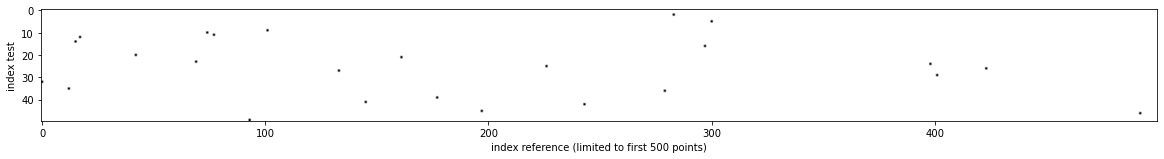

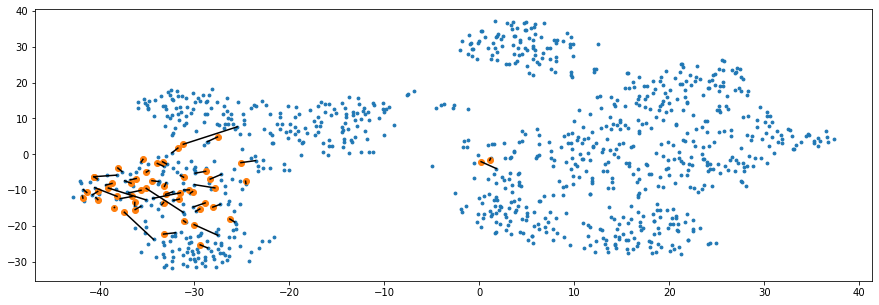

In [34]:
this_test = test_features_imbal
_, coupling = wasserstein(ref_features[:-50], this_test, fraction_to_match=0.05, return_coupling=True, n_perm=None)

pyplot.figure(figsize=(20, 10))
ccut = coupling[:, :-1]
pyplot.imshow(ccut[:500].t(), cmap=pyplot.cm.gray_r)
pyplot.ylabel('index test')
pyplot.xlabel('index reference (limited to first 500 points)')
idxes = ccut.argmax(0)
pyplot.savefig('plot_coupling.pdf')
pyplot.show()
#kernel_mmd(ref_features[idxes], this_test, n_perm=None)

import sklearn.manifold

tsne = sklearn.manifold.TSNE()

all_feat = torch.cat([ref_features[:-50], this_test])
feat_red = tsne.fit_transform(all_feat)

pyplot.figure(figsize=(15, 5))
pyplot.scatter(feat_red[:-this_test.size(0), 0], feat_red[:-this_test.size(0), 1], s=8)
pyplot.scatter(feat_red[-this_test.size(0):, 0], feat_red[-this_test.size(0):, 1])


pts = numpy.stack([feat_red[idxes], feat_red[-this_test.size(0):]], axis=2)

pyplot.plot(pts[:, 0].T, pts[:, 1].T, color='black');
pyplot.savefig('match_coupling.pdf')
